In [2]:
# Import all necessary libraries.
import numpy as np
from scipy.special import erfc
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

In [3]:
# Number of QPSK symbols to be transmitted.
N = 1000000

In [4]:
# Instantiate a Gaussian naive Bayes classifier for each one of the parts of a QPSK symbol.
gnb_re = GaussianNB()
gnb_im = GaussianNB()

In [28]:
# Create Es/N0 vector.
EsN0dB = np.arange(-2,22,2)

ser_simu = np.zeros(len(EsN0dB))
ser_theo = np.zeros(len(EsN0dB))

for idx in range(0,len(EsN0dB)):
    
    print('Es/N0 dB:', EsN0dB[idx])
    
    EsN0Lin = 10.0**(-(EsN0dB[idx]/10.0))
    
    # Generate N QPSK symbols.
    ip =(2.0 * (np.random.rand(N, 1) >= 0.5) - 1.0) + 1j*(2.0 * (np.random.rand(N, 1) >= 0.5) - 1.0)
    
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    
    # Generate noise vector. 
    # Divide by two once the theoretical ber uses a complex Normal pdf with variance of each part = 1/2.
    noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
    
    # Pass symbols through AWGN channel.
    y = s + np.sqrt(EsN0Lin)*noise
    
    #Antes de testar e validar o modelo, os exemplos e labels devem ser divididos em conjunto de treinamento e
    #validação. Como há parte real e im. Ambas partes devem ser divididas. (https://docs.python.org/2/library/cmath.html)
    
    x_test_real, x_train_real, y_test_real, y_train_real = train_test_split(ip.real, y.real)
    
    x_test_j, x_train_j, y_test_j, y_train_j = train_test_split(ip.imag, y.imag)
    
    # Fit models for real part.
    gnb_re.fit(y_train_real, x_train_real.ravel())
    
    # Fit model for imaginary parts.
    gnb_im.fit(y_train_j, x_train_j.ravel())
    
    # Prediction for real part.
    detected_ip_re = gnb_re.predict(y_test_real)
    detected_ip_re = detected_ip_re.reshape(len(y_test_real), 1)
    
    # Prediction for imaginary part.
    detected_ip_im = gnb_im.predict(y_test_j)
    detected_ip_im = detected_ip_im.reshape(len(y_test_j), 1)    
        
    # Simulated QPSK BER.
    error_re = (x_test_real != detected_ip_re)
    error_im = (x_test_j != detected_ip_im)
    error = 0;
    for i in range(0, len(x_test_real)): 
        if(error_re[i]==True or error_im[i]==True): 
            error = error + 1
    
    ser_simu[idx] = 1.0 * error / len(x_test_real)
    
    # Theoretical BPSK BER.    
    ser_theo[idx] = erfc( np.sqrt(  0.5*(10.0**(EsN0dB[idx]/10.0))   ) ) - (1/4)*(erfc(np.sqrt(0.5*(10.0**(EsN0dB[idx]/10.0)))))**2.0;

Es/N0 dB: -2
Es/N0 dB: 0
Es/N0 dB: 2
Es/N0 dB: 4
Es/N0 dB: 6
Es/N0 dB: 8
Es/N0 dB: 10
Es/N0 dB: 12
Es/N0 dB: 14
Es/N0 dB: 16
Es/N0 dB: 18
Es/N0 dB: 20


In [29]:
ser_simu

array([3.81758667e-01, 2.91730667e-01, 1.97341333e-01, 1.09509333e-01,
       4.58946667e-02, 1.20266667e-02, 1.47333333e-03, 7.46666667e-05,
       1.33333333e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

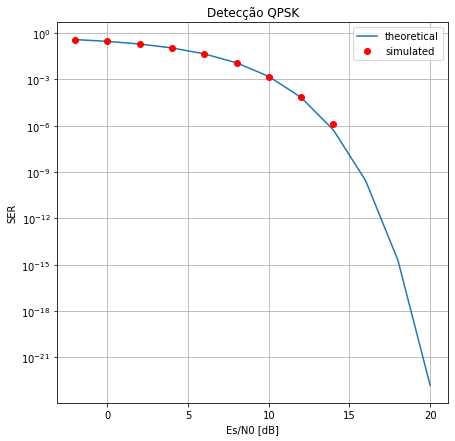

In [31]:
#Es/N0 vs. SER teórica e simulada
fig = plt.figure(figsize=(7,7))

plt.plot(EsN0dB, ser_theo, label='theoretical')
plt.plot(EsN0dB, ser_simu, 'ro', label='simulated')

plt.xscale('linear')
plt.yscale('log')

plt.xlabel('Es/N0 [dB]')
plt.ylabel('SER')

plt.grid(True)

plt.title('Detecção QPSK')

plt.legend()


plt.show()

In [ ]:
'''
C) Sim. A curva simulada se aproxima da curva teórica da SER.

D)Se tratando de símbolos com diferentes probabilidades, ML não é equivalente a MAP. A equação que maximiza o numera-
dor, é a mesma para ML e MAP, somente se os símbolos são equiprováveis.
'''